# Used Car Pricing Algorithm

## Environment

In [1]:
import numpy as np
import pandas as pd

In [2]:
# show 100 rows, 50 columns
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
def print_shape(df):
    print(f"Rows: {df.shape[0]:,} \nColumns: {df.shape[1]:,}")

In [4]:
def print_rows(df):
    print(f"Rows: {df.shape[0]:,}")

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def assess_results(y_test, y_pred):
    print("R2: ", round(r2_score(y_test, y_pred),3))
    print("MAE: ", round(mean_absolute_error(y_test, y_pred),2))
    print("MAPE: ", round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,1),"%")
    print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print("Percent Underpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) >= 0]) / len(y_test) * 100,1),"%")
    print("Mean of Underpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) > 0]),2))
    print("Percent Overpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) < 0]) / len(y_test) * 100,1),"%")
    print("Mean of Overpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) < 0]),2))
    print("Mean Error: ", round(np.mean(y_test - y_pred),2)) 
    

## Load Data

In [5]:
%%time

data_dir = "/data/p_dsi/capstone_projects/shea/4_merged/"
filename = "merged_structured_new.pkl"

df = pd.read_pickle(data_dir + filename)
print_shape(df)

Rows: 12,984,106 
Columns: 44
CPU times: user 1min 37s, sys: 9.2 s, total: 1min 47s
Wall time: 2min 20s


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12984106 entries, 0 to 12984105
Data columns (total 44 columns):
 #   Column               Dtype         
---  ------               -----         
 0   vin                  object        
 1   price                float64       
 2   miles                float64       
 3   year                 float64       
 4   make                 object        
 5   model                object        
 6   trim                 object        
 7   vehicle_type         object        
 8   body_type            object        
 9   body_subtype         object        
 10  drivetrain           object        
 11  fuel_type            object        
 12  engine_block         object        
 13  engine_size          object        
 14  transmission         object        
 15  doors                float64       
 16  cylinders            float64       
 17  city_mpg             float64       
 18  highway_mpg          float64       
 19  base_exterior_color

In [7]:
# datatype conversions
df["status_date"] = pd.to_datetime(df["status_date"], unit='s')
df["engine_size"] = df["engine_size"].astype("float")

In [8]:
df_original = df.copy()

In [9]:
# start over without reloading from file
#df = df_original.copy()

Title registration is the source of truth for purchase date, price, and mileage. Listing for everything else...

## Fatally Missing or Inaccurate Values
Not appropriate to impute these since they're too important

### Price

In [10]:
# price missing
print(df["mvr_price"].isna().sum())
df = df[~df["mvr_price"].isna()]
print_rows(df)

961422
Rows: 12,022,684


In [11]:
# price ~ 0
print((df["mvr_price"] < 10).sum())
df = df[~(df["mvr_price"] < 10)]
print_rows(df)

2515073
Rows: 9,507,611


### Mileage

In [12]:
# drop if miles missing
print(df["mvr_mileage"].isna().sum())
print((df["mvr_mileage"] == 0).sum())
df = df[~(df["mvr_mileage"].isna() | (df["mvr_mileage"] == 0))]
print_rows(df)

6124
95429
Rows: 9,406,058


In [13]:
# keep only actual mileage
print(df["mvr_odometer_brand"].value_counts())
df = df[df["mvr_odometer_brand"] == "Actual"]
print_rows(df)

Actual            8706378
Unknown            668814
Not Actual          28691
Exceeds Limits       2175
Name: mvr_odometer_brand, dtype: int64
Rows: 8,706,378


### Purchase Date

In [14]:
# drop missing purchase date
print(df["mvr_purchase_date"].isna().sum())
df = df[~(df["mvr_purchase_date"].isna())]
print_rows(df)

10
Rows: 8,706,368


In [15]:
# drop purchase date pre-2018
print((df["mvr_purchase_date"] < pd.to_datetime('20180101', format='%Y%m%d')).sum())
df = df[~(df["mvr_purchase_date"] < pd.to_datetime('20180101', format='%Y%m%d'))]
print_rows(df)

42916
Rows: 8,663,452


## Match Verification
Check with fuzzy matching

### Model Year

In [16]:
# model year
print(sum(df["year"] != df["mvr_model_year"]))
df = df[df["year"] == df["mvr_model_year"]]
print_rows(df)

21827
Rows: 8,641,625


### Make

In [17]:
from fuzzywuzzy import fuzz

# define a function to calculate the similarity score
def get_similarity(row):
    return fuzz.ratio(row['make'].lower(), row['mvr_make'].lower())

In [18]:
# prep
df.loc[df["make"].str.strip().str.lower() == 'gmc',"make"] = "GENERAL MOTORS"
df.loc[df["mvr_make"].str.strip().str.lower() == 'gmc',"mvr_make"] = "GENERAL MOTORS"

df.loc[df["make"].str.strip().str.lower() == 'ram',"make"] = "DODGE"
df.loc[df["mvr_make"].str.strip().str.lower() == 'ram',"mvr_make"] = "DODGE"

df.loc[df["make"].str.strip().str.lower() == 'scion',"make"] = "TOYOTA"
df.loc[df["mvr_make"].str.strip().str.lower() == 'scion',"mvr_make"] = "TOYOTA"
df.loc[df["mvr_make"].str.strip().str.lower() == 'scio',"mvr_make"] = "TOYOTA"

df.loc[df["make"].str.strip().str.lower() == 'genesis',"make"] = "HYUNDAI"
df.loc[df["mvr_make"].str.strip().str.lower() == 'genesis',"mvr_make"] = "HYUNDAI"
df.loc[df["mvr_make"].str.strip().str.lower() == 'genes',"mvr_make"] = "HYUNDAI"
df.loc[df["mvr_make"].str.strip().str.lower() == 'gene',"mvr_make"] = "HYUNDAI"
df.loc[df["mvr_make"].str.strip().str.lower() == 'gen',"mvr_make"] = "HYUNDAI"
df.loc[df["mvr_make"].str.strip().str.lower() == 'gens',"mvr_make"] = "HYUNDAI"

df.loc[df["mvr_make"].str.strip().str.lower() == 'kia motors corp',"mvr_make"] = "kia"

In [19]:
make_similarity = df[["make","mvr_make"]].apply(get_similarity, axis=1)

In [20]:
threshold = 35
not_match = make_similarity < threshold
print(sum(not_match))
df = df[~not_match]
print_rows(df)

763
Rows: 8,640,862


### Mileage
We're allowing for some discrepancy because of the way records were deduplicated. Prior sale listings might be matched with subsequent title registrations. Shouldn't be a problem since the listings are used for vehicle attributes that generally don't change with time (model, features, etc). Attributes that change with time are coming from the registration (age, mileage, price).

In [21]:
df["mvr_mileage"] = df["mvr_mileage"].astype(float)

In [67]:
# average annual mileage = 13k (https://www.fhwa.dot.gov/ohim/onh00/bar8.htm)
# not allowing discrepancy to exceed twice the annual average mileage
mileage_diff = abs(df["mvr_mileage"] - df["miles"])
print(sum((mileage_diff > 2*13000) & (df["miles"] != 0)))
df = df[~((mileage_diff > 2*13000) & (df["miles"] != 0))]
print_rows(df)

284618
Rows: 6,635,276


### Listing Date vs Purchase Date
Allowing for one year difference in line with those explained for mileage.

In [68]:
list_sale_diff = abs((df['mvr_purchase_date'] - df['status_date']).astype('timedelta64[D]'))
print(sum(list_sale_diff > 365))
df = df[~(list_sale_diff > 365)]
print_rows(df)

262031
Rows: 6,373,245


## Business Case Exclusions

### Consumer Cars and Trucks Only
Exclude commerical and recreational vehicles

In [24]:
# consumer cars and trucks
# df["body_type"].value_counts()

excluded_vehtypes = ["Cargo Van","Passenger Van","Chassis Cab","Car Van"
                     ,"Combi","Cutaway","Van","Commercial Wagon","Chassis Cowl"]

print(df["body_type"].isin(excluded_vehtypes).sum())
df = df[~df["body_type"].isin(excluded_vehtypes)]
print_shape(df)

89942
Rows: 8,535,863 
Columns: 44


### Not Vintage
Vehicles older than 20 years can qualify for an antique plate

In [25]:
# difference between purchase date and estimated model year release
# model year can be introduced as early as january of prior calendar year
# generally august/sept of prior calendar year (going with june prior year)
age_calc = df["mvr_purchase_date"] - pd.to_datetime((df['year'].astype(int)-1).astype(str) + '0601', format='%Y%m%d')

# compute age in months
df["age_months"] = np.round(age_calc.astype('timedelta64[s]') / (30.44*24*60*60)).astype(int)

In [26]:
# drop 20+ years old
print((df["age_months"] >= 240).sum())
df = df[df["age_months"] < 240]
print_rows(df)

37564
Rows: 8,498,299


In [27]:
# drop problematic negative age
print((df["age_months"] < 1).sum())
df = df[~(df["age_months"] < 1)]
print_rows(df)

1600
Rows: 8,496,699


### International

In [28]:
# canadians/mexicans
print((df["currency_indicator"] == "CAD").sum())
df = df[~(df["currency_indicator"] == "CAD")]

print((df["miles_indicator"] == "KILOMETERS").sum())
df = df[~(df["miles_indicator"] == "KILOMETERS")]

print_rows(df)

10
168
Rows: 8,496,521


### Mileage
- Low mileage cars aren't really "used"
- Not interested in dealing extremely high mileage vehicles

In [29]:
# calculate high and low prices
top = df["mvr_mileage"].quantile(0.95)
print(top)
print(sum(df["mvr_mileage"] > top))
bottom = df["mvr_mileage"].quantile(0.05)
print(bottom)
print(sum(df["mvr_mileage"] < bottom))

148925.0
424815
861.0
424822


In [30]:
# drop
df = df[~((df["mvr_mileage"] > top) | (df["mvr_mileage"] < bottom))]
print_rows(df)

Rows: 7,646,884


### Drivetrain

In [31]:
print(sum(~df["drivetrain"].isin(["FWD", "RWD", "4WD"])))
df = df[df["drivetrain"].isin(["FWD", "RWD", "4WD"])]
print_rows(df)

28006
Rows: 7,618,878


### Salvage

In [88]:
# drop salvage vehicles
print((df["mvr_salvage"] == "Yes").sum())
df = df[~(df["mvr_salvage"] == "Yes")]
print_rows(df)

13311
Rows: 6,359,934


## Make, Model, Trim
Central to target encoding. Need at least 1000 observations of make/model/trim combo

In [32]:
# make, model, or trim is null
print((df["make"].isna() | df["model"].isna() | df["trim"].isna()).sum())
df = df[~(df["make"].isna() | df["model"].isna() | df["trim"].isna())]
print_rows(df)

1541
Rows: 7,617,337


In [33]:
# new make/model and make/model/trim col, for target encoding later
df['make_model_encode'] = df['make'] + ' / ' + df['model']
df['make_model_trim_encode'] = df['make'] + ' / ' + df['model'] + ' / ' + df['trim']

In [43]:
# drop make/model/trim <1000 obs
print(sum(df["make_model_trim_encode"].value_counts()[df["make_model_trim_encode"].value_counts() < 1000]))
df = df[~df['make_model_trim_encode'].isin(list((df["make_model_trim_encode"].value_counts()[df["make_model_trim_encode"].value_counts() < 1000]).index))]
print_rows(df)

691717
Rows: 6,925,620


In [45]:
df["make_model_trim_encode"].nunique()

1066

## Target Variable

We're not sellin' Ferraris and Lamborghinis here. We're sellin' everyday used cars.

In [48]:
# calculate high and low prices
top = df["mvr_price"].quantile(0.999)
print(round(top))
bottom = df["mvr_price"].quantile(0.001)
print(round(bottom))

97726
500


Based on manual inspection, records with `mvr_price` over 300,000 become highly error-prone. Extensive data validation is beyond the scope of this project, and these records will be dumped. Further, prices above 100,000 are not under considation for most used car businesses.

In [53]:
# remove
print(sum((df["mvr_price"] > 100000)))
df = df[~(df["mvr_price"] > 100000)]
print_rows(df)

5587
Rows: 6,919,894


<AxesSubplot:>

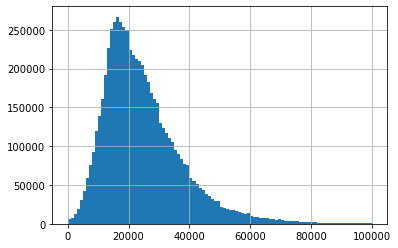

In [69]:
# plot distribution of mvr_price
df["mvr_price"].hist(bins=100)

Based on manual inspection, records with `mvr_price` under $X become highly error-prone. Extensive data validation is beyond the scope of this project, and these records will be dumped.

In [74]:
sum(df["mvr_price"] < 1000)

4264

In [75]:
df.loc[df["mvr_price"] < 1000,["price","mvr_price","mvr_salvage","make","mvr_make","mvr_purchase_date","status_date","mvr_model_year","miles","mvr_mileage"]].sort_values(by="mvr_price", ascending=True).sample(100)

,price,mvr_price,mvr_salvage,make,mvr_make,mvr_purchase_date,status_date,mvr_model_year,miles,mvr_mileage
9811897,6900.00,100.00,No,Ford,FORD,2022-01-20,2021-04-23 03:30:32,2005,84863.00,86500.00
12401470,1995.00,200.00,No,Hyundai,HYUNDAI,2019-08-02,2018-12-10 16:42:42,2009,119011.00,123470.00
12896972,35750.00,575.00,No,Chevrolet,CHEVROLET,2018-01-31,2018-02-01 16:59:33,2004,NaN,104492.00
7089990,NaN,350.00,No,Buick,BUIC,2019-02-08,2018-03-03 09:52:32,2013,124869.00,136426.00
11228431,3899.00,500.00,No,Jeep,JEEP,2019-09-10,2019-07-16 01:19:43,2004,140382.00,143423.00
1704813,NaN,200.00,Unknown,Ford,FORD,2022-08-08,2021-12-18 06:00:03,2013,132866.00,140086.00
10517827,NaN,500.00,No,Toyota,TOYOTA MOTOR CO,2022-06-13,2022-04-28 23:22:12,2007,146041.00,146200.00
9607332,NaN,500.00,No,Chevrolet,CHEVROLET,2022-10-18,2021-11-08 09:29:08,2011,116900.00,116958.00
3793787,NaN,651.96,No,Ford,FORD,2020-05-15,2020-01-17 21:14:26,2013,53001.00,53001.00
8129094,9995.00,800.00,No,Chrysler,CHRY,2022-05-03,2022-04-26 11:36:09,2015,68559.00,84347.00


In [ ]:
# plot distribution of mvr_price
#df["mvr_price"].hist(bins=100)

### Investigate Price Distribution for Relevant Subtypes

In [77]:
import matplotlib.pyplot as plt

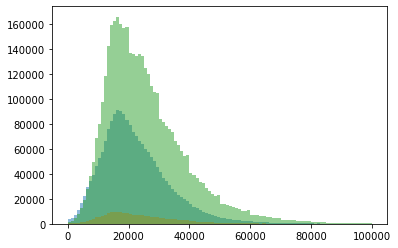

In [79]:
# by state
grouped = df.groupby('mvr_state')
for name, group in grouped:
    plt.hist(group['mvr_price'], bins=100, alpha=0.5, label=name)
plt.show()

## Subset Columns

In [89]:
df.columns

Index(['vin', 'price', 'miles', 'year', 'make', 'model', 'trim',
       'vehicle_type', 'body_type', 'body_subtype', 'drivetrain', 'fuel_type',
       'engine_block', 'engine_size', 'transmission', 'doors', 'cylinders',
       'city_mpg', 'highway_mpg', 'base_exterior_color', 'base_interior_color',
       'is_certified', 'is_transfer', 'scraped_at', 'status_date',
       'first_scraped_at', 'city', 'zip', 'latitude', 'longitude',
       'dealer_type', 'currency_indicator', 'miles_indicator',
       'photo_links_count', 'hvf_standard', 'hvf_optional',
       'mvr_purchase_date', 'mvr_price', 'mvr_make', 'mvr_mileage',
       'mvr_model_year', 'mvr_odometer_brand', 'mvr_salvage', 'mvr_state',
       'age_months', 'make_model_encode', 'make_model_trim_encode'],
      dtype='object')

In [92]:
df = df[['mvr_price',
       'make', 'model', 'trim', 'mvr_model_year','mvr_mileage','age_months',
       'vehicle_type', 'body_type', 'body_subtype', 'drivetrain', 'fuel_type',
       'engine_block', 'engine_size', 'transmission', 'doors', 'cylinders',
       'city_mpg', 'highway_mpg',
       'base_exterior_color', 'base_interior_color',
       'is_certified',  
       'zip','mvr_state',
       'hvf_standard', 'hvf_optional',
       'mvr_purchase_date',
        'make_model_encode', 'make_model_trim_encode']]

## Additional Feature Engineering

In [ ]:
# purchase month
df["mvr_purchase_month"] = df["mvr_purchase_date"].dt.month.astype("category")

In [ ]:
# monthly mileage
df["monthly_mileage"] = round(df["mvr_mileage"]/df["age_months"],1)

In [ ]:
# epa weights city/highway 55/45
df["mpg"] = df["city_mpg"] * 0.55 + df["highway_mpg"] * 0.45
df.drop(columns=["city_mpg", "highway_mpg"], inplace=True)

In [ ]:
# consolidate fuel types
mapping = {"Lpg / Natural Gas":"Natural Gas"
           ,"Unleaded / Premium Unleaded":"Premium Unleaded"
           ,"E85; Unleaded ":"E85 / Unleaded"
           ,"E85 / Unleaded; Premium Unleaded":"Premium Unleaded"
           ,"Compressed Natural Gas; Unleaded":"Natural Gas"
           ,"Unleaded; Unleaded / E85":"E85 / Unleaded"
           ,"E85 / Unleaded; Unleaded / E85 ":"E85 / Unleaded"
           ,"Unleaded / Electric":"Electric / Unleaded"
           ,"Compressed Natural Gas / Unleaded":"Natural Gas"
           ,"Premium Unleaded; Unleaded":"Premium Unleaded"
           ,"E85 / Unleaded; Unleaded / Unleaded":"E85 / Unleaded"
           ,"Compressed Natural Gas":"Natural Gas"
           ,"Unleaded / Unleaded":"Unleaded"
           ,"Premium Unleaded / Unleaded":"Premium Unleaded"
           ,"E85 / Unleaded; Unleaded":"E85 / Unleaded"
           ,"Unleaded / E85":"E85 / Unleaded"
          }

df['fuel_type'] = df['fuel_type'].map(mapping).fillna(df['fuel_type'])

In [ ]:
# zip first five
df['zip'] = df['zip'].str[:5]

### Local Features

In [99]:
from uszipcode import SearchEngine
search = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.comprehensive) 

In [100]:
def get_population_density_and_income(zipcode):
    result = search.by_zipcode(zipcode)
    if result:
        return pd.Series([result.population_density
                          ,result.median_household_income
                          ,result.median_home_value
                         ])
    else:
        return pd.Series([None, None, None])

In [101]:
# apply get_population_density_and_income to each value in zip_list
zip_list = pd.DataFrame(df['zip'].unique(), columns=['zip'])
zip_list[['population_density', 'median_income', 'median_home_value']] = zip_list['zip'].apply(get_population_density_and_income)
df = df.merge(zip_list, on='zip', how='left')

### Economic

In [102]:
df["mvr_purchase_yearmonth"] = df["mvr_purchase_date"].dt.strftime('%Y-%m')

In [103]:
# federal reserve economic data (fred)
from fredapi import Fred
fred = Fred(api_key_file='private/fred_api_key.txt')

#### Used Car Price Index

In [104]:
# BLS: Used cars and trucks in U.S. city average
used_car_price_index = fred.get_series('CUUR0000SETA02')
used_car_price_index.name = "used_car_price_index"
used_car_price_index.index = used_car_price_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
used_car_price_index.index = used_car_price_index.index.strftime('%Y-%m')
df = df.join(used_car_price_index, on="mvr_purchase_yearmonth", how="left")

#### New Car Price Index

In [105]:
# BLS: New cars and trucks in U.S. city average
new_car_price_index = fred.get_series('CUSR0000SETA01')
new_car_price_index.name = "new_car_price_index"
new_car_price_index.index = new_car_price_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
new_car_price_index.index = new_car_price_index.index.strftime('%Y-%m')
df = df.join(new_car_price_index, on="mvr_purchase_yearmonth", how="left")

#### Gas Prices

In [106]:
gas_price_index = fred.get_series('GASREGW')
gas_price_index.name = "gas_price_index"
gas_price_index = gas_price_index.groupby(pd.Grouper(freq='M')).mean().resample('M').mean()
gas_price_index.index = gas_price_index.index + pd.DateOffset(months=1) # shift index 
gas_price_index.index = gas_price_index.index.strftime('%Y-%m')
df = df.join(gas_price_index, on="mvr_purchase_yearmonth", how="left")

#### Consumer Sentiment

In [107]:
consumer_sentiment_index = fred.get_series('UMCSENT')
consumer_sentiment_index.name = "consumer_sentiment_index"
consumer_sentiment_index.index = consumer_sentiment_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
consumer_sentiment_index.index = consumer_sentiment_index.index.strftime('%Y-%m')
df = df.join(consumer_sentiment_index, on="mvr_purchase_yearmonth", how="left")

### "High Value Features" Vehicle Options
- Optional features will be useful in combination with make/model/trim
- Standard+Optional features will be useful in combination with make/model/trim

In [108]:
from tqdm import tqdm
tqdm.pandas()

In [109]:
def make_series(x):
    return pd.Series(x, dtype = object)

#### Optional

In [111]:
# produce dummy vars
hvf_optional = df["hvf_optional"]
hvf_optional_df = pd.get_dummies(hvf_optional.progress_apply(make_series).stack()).groupby(level=0).sum()
hvf_optional_df = hvf_optional_df.fillna(0)
hvf_optional_df = hvf_optional_df.add_prefix('hvf_opt_')
print(hvf_optional_df.shape)

100%|██████████| 6359934/6359934 [29:54<00:00, 3544.70it/s]  


(2371882, 77)


#### Optional and Standard

In [136]:
# function to append two lists
def combine_hvf(row):
    if row["hvf_optional"] is None:
        row["hvf_optional"] = []
    if row["hvf_standard"] is None:
        row["hvf_standard"] = []
    else:
        return list(set(list(row["hvf_optional"]) + list(row["hvf_standard"])))

In [138]:
# combine unique features across two lists
hvf_all = df.progress_apply(combine_hvf, axis=1)

100%|██████████| 6359934/6359934 [03:18<00:00, 32046.86it/s]


In [145]:
# create dummy vars
hvf_all_df = pd.get_dummies(hvf_all.progress_apply(make_series).stack()).groupby(level=0).sum()
hvf_all_df = hvf_all_df.fillna(0)
hvf_all_df = hvf_all_df.add_prefix('hvf_all_')
print(hvf_optional_df.shape)

100%|██████████| 6359934/6359934 [38:07<00:00, 2780.02it/s]  


(2371882, 77)


#### Flag Records with No Features Data

In [151]:
df["hvf_opt_missing"] = 0
df.loc[df["hvf_optional"].isna(),"hvf_opt_missing"] = 1

In [152]:
df["hvf_std_missing"] = 0
df.loc[df["hvf_standard"].isna(),"hvf_std_missing"] = 1

In [ ]:
#df = df.drop(columns=["hvf_optional","hvf_standard"])

## Checkpoint

In [154]:
working_dir = "/data/p_dsi/capstone_projects/shea/working/"
df.to_pickle(working_dir + "df.pkl")
hvf_all_df.to_pickle(working_dir + "hvf_all_df.pkl")
hvf_optional_df.to_pickle(working_dir + "hvf_optional_df.pkl")

In [ ]:
working_dir = "/data/p_dsi/capstone_projects/shea/working/"
df = pd.read_pickle(working_dir + "df.pkl")
hvf_all_df = pd.read_pickle(working_dir + "hvf_all_df.pkl")
hvf_optional_df = pd.read_pickle(working_dir + "hvf_optional_df.pkl")

---
---
---
---
---
---
---
---
---
---
---
---

## Restore Checkpoint

In [1]:
# resume checkpoint

import numpy as np
import pandas as pd

working_dir = "/data/p_dsi/capstone_projects/shea/working/"
df = pd.read_pickle(working_dir + "df.pkl")
hvf_optional_df = pd.read_pickle(working_dir + "hvf_optional_df.pkl")
hvf_all_df = pd.read_pickle(working_dir + "hvf_all_df.pkl")

def print_shape(df):
    print(f"Rows: {df.shape[0]:,} \nColumns: {df.shape[1]:,}")
def print_rows(df):
    print(f"Rows: {df.shape[0]:,}")

## Data Split

In [2]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# shuffle dataframe for good measure
df = df.sample(frac=1, random_state=42)

# create StratifiedShuffleSplit object by make_model_trim column
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_index, temp_index = next(sss.split(df, df['make_model_trim_encode']))

# create StratifiedShuffleSplit object by make_model_trim column again
df_temp = df.loc[temp_index]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
val_index, test_index = next(sss.split(df_temp, df_temp['make_model_trim_encode']))

# split dataframe into train, validate, and test sets
train = df.loc[train_index]
validate = df.loc[temp_index[val_index]]
test = df.loc[temp_index[test_index]]


In [3]:
print("Train")
print_rows(train)
print("\nValidate")
print_rows(validate)
print("\nTest")
print_rows(test)

Train
Rows: 4,451,953

Validate
Rows: 1,278,347

Test
Rows: 629,634


## Windsorize Price

In [4]:
# windsorize function
#def windsorize(train, column, lower_percentile=0.05, upper_percentile=0.95):
#    lower_limit = train[column].quantile(lower_percentile)
#    upper_limit = train[column].quantile(upper_percentile)
#    train[column] = train[column].clip(lower=lower_limit, upper=upper_limit)
#    print(f'{lower_limit} - {upper_limit}')
#    return lower_limit, upper_limit

# calc and apply to train
#lower_limit, upper_limit = windsorize(train, "mvr_price", lower_percentile=0, upper_percentile=0.99)

# apply to validate, test
#validate["mvr_price"] = validate["mvr_price"].clip(lower=lower_limit, upper=upper_limit)
#test["mvr_price"] = test["mvr_price"].clip(lower=lower_limit, upper=upper_limit)

## Target Encoding

In [5]:
import category_encoders as ce

In [6]:
# fit encoder for make/model/trim
encoder = ce.TargetEncoder(cols=['make_model_trim_encode'])
encoder.fit(train, train["mvr_price"])

# apply transformation
train = encoder.transform(train)
validate = encoder.transform(validate)
test = encoder.transform(test)

In [7]:
# fit encoder for make/model/trim
encoder = ce.TargetEncoder(cols=['make_model_encode'])
encoder.fit(train, train["mvr_price"])

# apply transformation
train = encoder.transform(train)
validate = encoder.transform(validate)
test = encoder.transform(test)

## HVF Dimsionality Reduction

In [8]:
hvf_optional_df = hvf_optional_df.clip(upper=1)
hvf_all_df = hvf_all_df.clip(upper=1)

In [9]:
from sklearn.decomposition import PCA

def reduce_hvf(df,pca=None,comp_prefix=""):
    
    # compute pca if not provided
    if not pca:
        pca = PCA(n_components=9)
        pca.fit(df)
    
    transformed_df = pca.transform(df)
    transformed_df = pd.DataFrame(transformed_df, columns=['comp_0','comp_1', 'comp_2'
                                                       ,'comp_3','comp_4', 'comp_5'
                                                       ,'comp_6','comp_7', 'comp_8'
                                                                  ])
    transformed_df = transformed_df.add_prefix(comp_prefix)
    
    transformed_df.index = df.index
    print_shape(transformed_df)
    return transformed_df,pca

In [10]:
train_index = train.index
validate_index = validate.index
test_index = test.index

### Optional

In [11]:
hvf_optional_train = hvf_optional_df.loc[hvf_optional_df.index.intersection(train_index),:]
hvf_optional_validate = hvf_optional_df.loc[hvf_optional_df.index.intersection(validate_index),:]
hvf_optional_test = hvf_optional_df.loc[hvf_optional_df.index.intersection(test_index),:]

In [12]:
hvf_optional_train,pca_train = reduce_hvf(hvf_optional_train,None,comp_prefix = "hvf_opt_")
hvf_optional_validate,_ = reduce_hvf(hvf_optional_validate,pca_train,comp_prefix = "hvf_opt_")
hvf_optional_test,_ = reduce_hvf(hvf_optional_test,pca_train,comp_prefix = "hvf_opt_")

Rows: 1,660,970 
Columns: 9
Rows: 476,238 
Columns: 9
Rows: 234,674 
Columns: 9


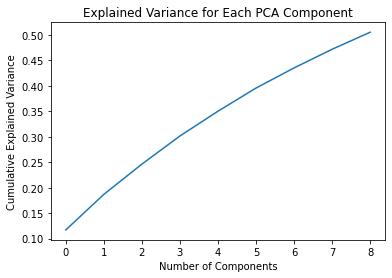

In [13]:
import matplotlib.pyplot as plt

# plot the explained variance for each component
plt.plot(np.cumsum(pca_train.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance for Each PCA Component')
plt.show()


### Optional and Standard

In [14]:
hvf_all_train = hvf_all_df.loc[hvf_all_df.index.intersection(train_index),:]
hvf_all_validate = hvf_all_df.loc[hvf_all_df.index.intersection(validate_index),:]
hvf_all_test = hvf_all_df.loc[hvf_all_df.index.intersection(test_index),:]

In [15]:
hvf_all_train,pca_train = reduce_hvf(hvf_all_train,None,comp_prefix = "hvf_all_")
hvf_all_validate,_ = reduce_hvf(hvf_all_validate,pca_train,comp_prefix = "hvf_all_")
hvf_all_test,_ = reduce_hvf(hvf_all_test,pca_train,comp_prefix = "hvf_all_")

Rows: 3,625,850 
Columns: 9
Rows: 1,040,234 
Columns: 9
Rows: 512,838 
Columns: 9


### Merge with DF

In [16]:
train = train.merge(hvf_optional_train,how='left', left_index=True, right_index=True)
validate = validate.merge(hvf_optional_validate,how='left', left_index=True, right_index=True)
test = test.merge(hvf_optional_test,how='left', left_index=True, right_index=True)

In [17]:
train = train.merge(hvf_all_train,how='left', left_index=True, right_index=True)
validate = validate.merge(hvf_all_validate,how='left', left_index=True, right_index=True)
test = test.merge(hvf_all_test,how='left', left_index=True, right_index=True)

In [22]:
hvf_cols = ['hvf_opt_comp_0', 'hvf_opt_comp_1', 'hvf_opt_comp_2', 'hvf_opt_comp_3',
       'hvf_opt_comp_4', 'hvf_opt_comp_5', 'hvf_opt_comp_6', 'hvf_opt_comp_7',
       'hvf_opt_comp_8', 'hvf_all_comp_0', 'hvf_all_comp_1', 'hvf_all_comp_2',
       'hvf_all_comp_3', 'hvf_all_comp_4', 'hvf_all_comp_5', 'hvf_all_comp_6',
       'hvf_all_comp_7', 'hvf_all_comp_8']

In [27]:
train[hvf_cols] = train[hvf_cols].fillna(0)
validate[hvf_cols] = validate[hvf_cols].fillna(0)
test[hvf_cols] = test[hvf_cols].fillna(0)

In [18]:
print_shape(train)
print_shape(validate)
print_shape(test)

Rows: 4,451,953 
Columns: 58
Rows: 1,278,347 
Columns: 58
Rows: 629,634 
Columns: 58


## Missing

In [19]:
# calculate percent missing for each field in df
def percent_missing(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )
    # Sort the table by percentage of missing descending
    mis_val_table = (
        mis_val_table[mis_val_table.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )
    # Print some summary information
    print(f"{mis_val_table.shape[0]} of {df.shape[1]} columns have missing values")
    # Return the dataframe with missing information
    return mis_val_table


In [28]:
# check for missing
print(percent_missing(train))
print(percent_missing(validate))
print(percent_missing(test))

19 of 58 columns have missing values
                     Missing Values  % of Total Values
body_subtype                3564345               80.1
hvf_optional                2790983               62.7
base_interior_color          968139               21.7
is_certified                 923956               20.8
hvf_standard                 826103               18.6
base_exterior_color          338201                7.6
engine_block                 266066                6.0
cylinders                    266065                6.0
engine_size                  264652                5.9
mpg                          190857                4.3
median_income                 32279                0.7
population_density            32279                0.7
median_home_value             32279                0.7
transmission                   1203                0.0
vehicle_type                    545                0.0
fuel_type                       399                0.0
doors                       

### Simple Handling

In [29]:
# certified
train["is_certified"].fillna(0, inplace=True)
validate["is_certified"].fillna(0, inplace=True)
test["is_certified"].fillna(0, inplace=True)

In [30]:
# location info missing
train = train[~train["zip"].isna()]
validate = validate[~validate["zip"].isna()]
test = test[~test["zip"].isna()]

In [40]:
# body subtype missing
train["is_certified"].fillna("None", inplace=True)
validate["is_certified"].fillna("None", inplace=True)
test["is_certified"].fillna("None", inplace=True)

### Impute Mode for Categoricals

In [35]:
# create for grouping
train['make_model_trim'] = train['make'] + ' / ' + train['model'] + ' / ' + train['trim']
validate['make_model_trim'] = validate['make'] + ' / ' + validate['model'] + ' / ' + validate['trim']
test['make_model_trim'] = test['make'] + ' / ' + test['model'] + ' / ' + test['trim']

In [34]:
# categoricals
categoricals = ["base_interior_color","base_exterior_color","engine_block"
                ,"transmission","vehicle_type","fuel_type","body_type"
                ,"drivetrain"]
group = 'make_model_trim'
for cat in categoricals:
    train[cat] = train.groupby(group)[cat].transform(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'))
    validate[cat] = validate[group].map(train.groupby(group)[cat].apply(lambda x: x.mode()[0]))
    test[cat] = test[group].map(train.groupby(group)[cat].apply(lambda x: x.mode()[0]))

### Impute Median for Numerics

In [36]:
# numerics
numerics = ["cylinders","engine_size","mpg","doors"]
groups = ["make_model_trim","engine_size","cylinders","body_type"]
for group in groups:
    for num in numerics:
        train[num] = train.groupby(group)[num].transform(lambda x: x.fillna(x.median()))
        validate[num] = validate[group].map(train.groupby(group)[num].median())
        test[num] = test[group].map(train.groupby(group)[num].median())

In [37]:
# remove grouping
train = train.drop(columns='make_model_trim')
validate = validate.drop(columns='make_model_trim')
test = test.drop(columns='make_model_trim')

### Impute Median for Zip Features

In [38]:
from sklearn.impute import SimpleImputer

# fit a median imputer on train
imputer = SimpleImputer(strategy='median')
imputer.fit(train[['population_density', 'median_income', 'median_home_value']])

# apply the median impute
train[['population_density', 'median_income', 'median_home_value']] = imputer.transform(train[['population_density', 'median_income', 'median_home_value']])
validate[['population_density', 'median_income', 'median_home_value']] = imputer.transform(validate[['population_density', 'median_income', 'median_home_value']])
test[['population_density', 'median_income', 'median_home_value']] = imputer.transform(test[['population_density', 'median_income', 'median_home_value']])


In [39]:
# check for missing
print(percent_missing(train))
print(percent_missing(validate))
print(percent_missing(test))

3 of 58 columns have missing values
              Missing Values  % of Total Values
body_subtype         3564280               80.1
hvf_optional         2790929               62.7
hvf_standard          826079               18.6
3 of 58 columns have missing values
              Missing Values  % of Total Values
body_subtype         1023707               80.1
hvf_optional          802093               62.7
hvf_standard          238110               18.6
3 of 58 columns have missing values
              Missing Values  % of Total Values
body_subtype          504216               80.1
hvf_optional          394953               62.7
hvf_standard          116792               18.5


## EDA

In [41]:
train.columns

Index(['mvr_price', 'make', 'model', 'trim', 'mvr_model_year', 'mvr_mileage',
       'age_months', 'vehicle_type', 'body_type', 'body_subtype', 'drivetrain',
       'fuel_type', 'engine_block', 'engine_size', 'transmission', 'doors',
       'cylinders', 'base_exterior_color', 'base_interior_color',
       'is_certified', 'zip', 'mvr_state', 'hvf_standard', 'hvf_optional',
       'mvr_purchase_date', 'make_model_encode', 'make_model_trim_encode',
       'mvr_purchase_month', 'monthly_mileage', 'mpg', 'population_density',
       'median_income', 'median_home_value', 'mvr_purchase_yearmonth',
       'used_car_price_index', 'new_car_price_index', 'gas_price_index',
       'consumer_sentiment_index', 'hvf_opt_missing', 'hvf_std_missing',
       'hvf_opt_comp_0', 'hvf_opt_comp_1', 'hvf_opt_comp_2', 'hvf_opt_comp_3',
       'hvf_opt_comp_4', 'hvf_opt_comp_5', 'hvf_opt_comp_6', 'hvf_opt_comp_7',
       'hvf_opt_comp_8', 'hvf_all_comp_0', 'hvf_all_comp_1', 'hvf_all_comp_2',
       'hvf_all_com

In [49]:
# numerics correlations with target
correlations = train.corr(method="pearson", numeric_only=True)["mvr_price"].sort_values(ascending=False)
correlations

mvr_price                   1.000000
make_model_trim_encode      0.815970
make_model_encode           0.723281
mvr_model_year              0.554421
hvf_all_comp_0              0.544098
engine_size                 0.528696
cylinders                   0.498184
used_car_price_index        0.294117
new_car_price_index         0.279147
gas_price_index             0.255726
hvf_all_comp_2              0.236434
hvf_all_comp_6              0.184695
hvf_all_comp_5              0.184531
hvf_opt_comp_7              0.134540
is_certified                0.124132
hvf_opt_comp_0              0.120883
hvf_all_comp_3              0.092443
median_home_value           0.078317
median_income               0.077814
hvf_all_comp_7              0.057093
hvf_opt_comp_5              0.042269
hvf_opt_comp_8              0.036862
hvf_opt_comp_4              0.011774
hvf_all_comp_8              0.001112
doors                      -0.005576
hvf_opt_comp_3             -0.014476
hvf_opt_comp_2             -0.017497
h

engine_size       AxesSubplot(0.125,0.125;0.227941x0.755)
mvr_mileage    AxesSubplot(0.398529,0.125;0.227941x0.755)
age_months     AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

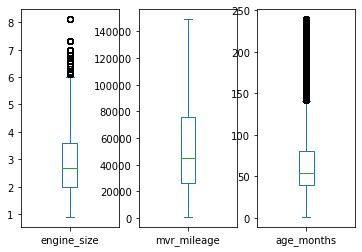

In [44]:
# boxplots of numeric variables
train[[
 'engine_size',
 'mvr_mileage',
 'age_months']].plot(kind='box', subplots=True, layout=(1,3), sharex=False, sharey=False)

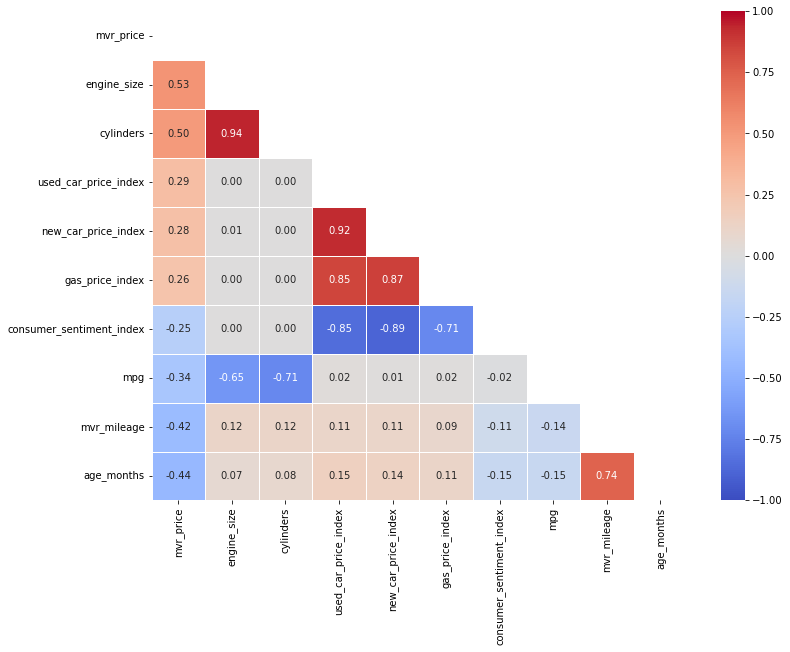

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_graph = ['mvr_price',
 'engine_size',
 'cylinders',
 'used_car_price_index',
 'new_car_price_index',
 'gas_price_index',
 'consumer_sentiment_index',
 'mpg',
 'mvr_mileage',
 'age_months']

corr_matrix = train[corr_graph].corr(numeric_only=True)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 9))

sns.heatmap(
    corr_matrix,
    mask=mask,        # Mask the upper triangle of the correlation matrix
    annot=True,       # Display the correlation coefficients
    fmt=".2f",        # Format the correlation coefficients to 2 decimal places
    cmap="coolwarm",  # Choose a color palette for the heatmap
    vmin=-1,          # Set the minimum value for the color scale
    vmax=1,           # Set the maximum value for the color scale
    linewidths=.5,    # Add a small space between the cells for better readability
)

# Display the heatmap
plt.show()


## Pre-Modeling EDA

In [57]:
print_shape(train)
train.sample(5).T


Rows: 4,451,874 
Columns: 58


,5423727,5461848,4091100,3845265,1650204
mvr_price,30250.0,21291.0,63793.0,28498.410156,14900.44043
make,Ford,Nissan,Ford,Mercedes-Benz,Ford
model,Explorer,Rogue,F-150,GLC,Mustang
trim,Sport,SL,XLT,GLC300,EcoBoost
mvr_model_year,2016,2016,2021,2016,2019
mvr_mileage,43045.0,28738.0,15972.0,47422.0,17681.0
age_months,47,44,29,81,54
vehicle_type,Truck,Truck,Truck,Truck,Car
body_type,SUV,SUV,Pickup,SUV,Coupe
body_subtype,None,None,Crew,None,None


## Checkpoint

In [ ]:
working_dir = "/data/p_dsi/capstone_projects/shea/working/"
train.to_pickle(working_dir + "train.pkl")
validate.to_pickle(working_dir + "validate.pkl")
test.to_pickle(working_dir + "test.pkl")

In [7]:
working_dir = "/data/p_dsi/capstone_projects/shea/working/"
train = pd.read_pickle(working_dir + "train.pkl")
validate = pd.read_pickle(working_dir + "validate.pkl")
test = pd.read_pickle(working_dir + "test.pkl")

## Model

### Column Inventory

#### HVF

In [8]:
# hvf columns
hvf_cols = [col for col in train.columns if col.startswith("hvf_")]
hvf_cols.remove("hvf_opt_missing")
hvf_cols.remove("hvf_std_missing")
hvf_cols.remove("hvf_optional")
hvf_cols.remove("hvf_standard")
hvf_cols

['hvf_opt_comp_0',
 'hvf_opt_comp_1',
 'hvf_opt_comp_2',
 'hvf_opt_comp_3',
 'hvf_opt_comp_4',
 'hvf_opt_comp_5',
 'hvf_opt_comp_6',
 'hvf_opt_comp_7',
 'hvf_opt_comp_8',
 'hvf_all_comp_0',
 'hvf_all_comp_1',
 'hvf_all_comp_2',
 'hvf_all_comp_3',
 'hvf_all_comp_4',
 'hvf_all_comp_5',
 'hvf_all_comp_6',
 'hvf_all_comp_7',
 'hvf_all_comp_8']

#### Numeric

In [9]:
# numeric columns
num_cols = train.select_dtypes(include=["number"]).columns.tolist()
num_cols.sort()
num_cols.remove("mvr_price")
for hvf_col in hvf_cols:
    num_cols.remove(hvf_col)
num_cols

['age_months',
 'consumer_sentiment_index',
 'cylinders',
 'doors',
 'engine_size',
 'gas_price_index',
 'hvf_opt_missing',
 'hvf_std_missing',
 'is_certified',
 'make_model_encode',
 'make_model_trim_encode',
 'median_home_value',
 'median_income',
 'monthly_mileage',
 'mpg',
 'mvr_mileage',
 'mvr_model_year',
 'mvr_price_bc',
 'new_car_price_index',
 'population_density',
 'used_car_price_index']

In [10]:
# categorical columns
cat_cols = list(train.columns)

# remove num cols
for num_col in num_cols:
    cat_cols.remove(num_col)
    
# remove hvf cols
for hvf_col in hvf_cols:
    cat_cols.remove(hvf_col)

# remove selected other cols
other_cols = ["hvf_optional","hvf_standard","mvr_purchase_date","mvr_purchase_yearmonth","zip"]
for other_col in other_cols:
    cat_cols.remove(other_col)

# remove target and cleanup
cat_cols.remove("mvr_price")
cat_cols.sort()
cat_cols

['base_exterior_color',
 'base_interior_color',
 'body_subtype',
 'body_type',
 'drivetrain',
 'engine_block',
 'fuel_type',
 'make',
 'model',
 'mvr_purchase_month',
 'mvr_state',
 'transmission',
 'trim',
 'vehicle_type']

In [11]:
# target
target = "mvr_price"

### Feature Prep

In [12]:
train[num_cols].sample(5).T

,442674,3302893,277994,5776477,6132058
age_months,68.00,26.00,68.00,93.00,90.00
consumer_sentiment_index,91.20,97.90,79.00,101.00,98.60
cylinders,6.00,6.00,8.00,4.00,6.00
doors,4.00,5.00,5.00,4.00,5.00
engine_size,3.60,3.50,5.30,2.40,3.60
gas_price_index,2.25,2.85,2.33,2.44,2.86
hvf_opt_missing,0.00,1.00,1.00,1.00,1.00
hvf_std_missing,0.00,1.00,0.00,0.00,1.00
is_certified,0.00,0.00,0.00,0.00,0.00
make_model_encode,25341.13,23373.83,42672.62,15145.65,24394.90


### Linear

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
# box-cox transform mvr_price
from scipy.stats import boxcox
from scipy.special import inv_boxcox

shift = 0

# calculate on the training set
train["mvr_price_bc"], lambda_bc = boxcox(train["mvr_price"] + shift)

# apply validation and test sets
validate["mvr_price_bc"] = boxcox(validate["mvr_price"] + shift, lambda_bc)
test["mvr_price_bc"] = boxcox(test["mvr_price"] + shift, lambda_bc)

/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/scipy/stats/morestats.py:912: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/lib/python3.9/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_sca

<AxesSubplot:>

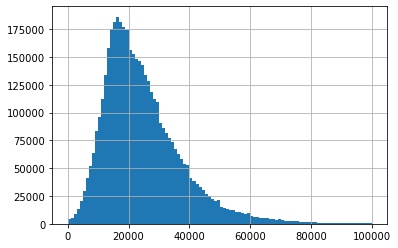

In [15]:
train["mvr_price"].hist(bins=100)

<AxesSubplot:>

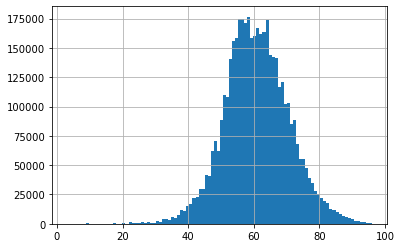

In [16]:
train["mvr_price_bc"].hist(bins=100)

In [17]:
# scale numeric columns
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

# fit
#scaler.fit(train[num_cols])

# transform
#train[num_cols] = scaler.transform(train[num_cols])
#validate[num_cols] = scaler.transform(validate[num_cols])
#test[num_cols] = scaler.transform(test[num_cols])


In [18]:
# correlation coefficients
corr_coef = train.corr(numeric_only=True)["mvr_price_bc"].abs().sort_values(ascending=False)
cor_picks = corr_coef[corr_coef > 0.2].index.tolist()
cor_picks

['mvr_price_bc',
 'mvr_price',
 'make_model_trim_encode',
 'make_model_encode',
 'mvr_model_year',
 'hvf_all_comp_0',
 'age_months',
 'engine_size',
 'cylinders',
 'mvr_mileage',
 'mpg',
 'hvf_opt_missing',
 'used_car_price_index',
 'new_car_price_index',
 'gas_price_index',
 'consumer_sentiment_index',
 'hvf_all_comp_2']

In [19]:
selected_num_cols = ['age_months',
                     'consumer_sentiment_index',
                     'cylinders',
                     'engine_size',
                     'gas_price_index',
                     
                     #'make_model_trim_encode',
                     #'hvf_opt_comp_0',
                     #'hvf_opt_comp_1',
                     #'hvf_opt_comp_2',
                     #'hvf_std_missing',
                     
                     'make_model_encode',
                     'hvf_all_comp_0',
                     'hvf_all_comp_1',
                     'hvf_all_comp_2',
                     'hvf_opt_missing',
                     
                     'mpg',
                     'mvr_mileage',
                     'mvr_model_year',
                     'new_car_price_index',
                     'used_car_price_index']

In [20]:
# fit
lr_model = LinearRegression()
lr_model.fit(train[selected_num_cols], train["mvr_price_bc"])

# predict
lr_preds = lr_model.predict(validate[selected_num_cols])
lr_preds_s = pd.Series(lr_preds)

# results
assess_results(validate.reset_index(drop=True).loc[(pd.Series(lr_preds) > 0.1),"mvr_price"]
               , inv_boxcox(lr_preds_s[lr_preds_s > 0.1], lambda_bc))



R2:  0.842
MAE:  3511.4
MAPE:  19.6 %
RMSE:  5121.91
Percent Underpayed:  53.2 %
Mean of Underpayment:  3986.23
Percent Overpayed:  46.8 %
Mean of Overpayment:  -2972.08
Mean Error:  728.35


### CatBoost

In [30]:
from catboost import CatBoostRegressor

In [24]:
selected_num_cols = ['age_months',
                     'mvr_mileage',
                     'mvr_model_year',
                     'doors',
                     'cylinders',
                     'engine_size',
                     'mpg',
                     'make_model_trim_encode',
                     'hvf_opt_comp_0',
                     'hvf_opt_comp_1',
                     'hvf_opt_comp_2',
                     'hvf_opt_comp_3',
                     'hvf_opt_comp_4',
                     'hvf_std_missing',
                     'hvf_opt_missing',
                     'gas_price_index',
                     'new_car_price_index',
                     'used_car_price_index',
                     'consumer_sentiment_index']

selected_cat_cols = ['base_exterior_color',
                     'base_interior_color',
                     'body_type',
                     'drivetrain',
                     'engine_block',
                     'fuel_type',
                     'mvr_purchase_month',
                     'mvr_state',
                     'transmission',
                     'vehicle_type']

In [ ]:
# init model
cb_model = CatBoostRegressor(cat_features=selected_cat_cols
                             ,verbose=False
                             ,task_type="GPU"
                             ,devices="0:3")

# fit
cb_model.fit(train[selected_num_cols + selected_cat_cols]
             ,train[target]
             ,eval_set=(validate[selected_num_cols + selected_cat_cols], validate[target])
            )

In [18]:
# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

In [19]:
# results
assess_results(validate[target], cb_preds)

R2:  0.882
MAE:  2959.25
MAPE:  17.1 %
RMSE:  4432.4
Percent Underpayed:  56.9 %
Mean of Underpayment:  3475.42
Percent Overpayed:  43.1 %
Mean of Overpayment:  -2276.67
Mean Error:  998.63


In [136]:
# best results
assess_results(validate[target], cb_preds)

R2:  0.894
MAE:  2837.78
MAPE:  16.8 %
RMSE:  4194.96
Percent Underpayed:  55.6 %
Mean of Underpayment:  3263.89
Percent Overpayed:  44.4 %
Mean of Overpayment:  -2304.39
Mean Error:  791.06


In [ ]:
# print top ten features by importance with importance measure
importance = cb_model.get_feature_importance(prettified=True)
importance.head(15)

### CatBoost Hyperparameter Tuning
https://catboost.ai/en/docs/concepts/parameter-tuning

https://catboost.ai/en/docs/references/training-parameters/common

In [52]:
# golden feature
# selected as a highly predictive feature for more splitting
gf_index = (selected_num_cols + selected_cat_cols).index('make_model_trim_encode')
gf_index = str(gf_index)

In [ ]:
# define hyperparameters to search over
param_grid = {
            'learning_rate': [0.2, 0.4]
            #,'iterations': [800,1200] # number of trees
            ,'depth': [6,10] # tree depth
            #,'l2_leaf_reg': [1, 3] # L2 regularization coefficient of the cost function
            ,'random_strength': [3, 5] # amount of randomness to use for scoring splits
            #,'bagging_temperature' : [1,8] # bagging aggressiveness [0,inf)
            #,'border_count': [128,254] # number of splits for numerical features
            }

# init model
cb_model = CatBoostRegressor(cat_features=selected_cat_cols
                             ,task_type="GPU"
                             ,devices="0:3"
                             #,iterations=1500
                             ,border_count=254
                             ,per_float_feature_quantization=gf_index+':border_count=1024'
                             ,verbose=False
                            )

grid_search_result = cb_model.grid_search(param_grid
                                       ,X=train[selected_num_cols + selected_cat_cols]
                                       ,y=train[target]
                                       ,cv=3
                                       ,verbose=False,
                                       #,plot=True
                                         )



In [47]:
grid_search_result['params']

{'bagging_temperature': 1,
 'random_strength': 3,
 'depth': 6,
 'l2_leaf_reg': 1,
 'learning_rate': 0.3}

In [57]:
# train the model with the best hyperparameters on the full training set
hpt_model = CatBoostRegressor(cat_features=selected_cat_cols
                             ,task_type="GPU"
                             ,devices="0:3"
                             ,iterations=500
                             ,border_count=254
                             ,per_float_feature_quantization=gf_index+':border_count=1024'
                             ,verbose=False
                             ,bagging_temperature=1
                             ,random_strength=3
                             ,depth=6
                             ,l2_leaf_reg=1
                             ,learning_rate=0.3
                            )

# fit
hpt_model.fit(train[selected_num_cols + selected_cat_cols]
             ,train[target]
             ,eval_set=(validate[selected_num_cols + selected_cat_cols], validate[target])
            )

In [58]:
# predict
hpt_preds = hpt_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], hpt_preds)

R2:  0.875
MAE:  3154.49
MAPE:  18.0 %
RMSE:  4563.97
Percent Underpayed:  58.9 %
Mean of Underpayment:  3679.74
Percent Overpayed:  41.1 %
Mean of Overpayment:  -2403.14
Mean Error:  1177.0


In [59]:
print('Feature importances:', hpt_model.feature_importances_)

Feature importances: [1.21057153e+00 9.69065038e+00 1.61357739e+01 1.39810980e+00
 2.84475697e+00 5.65069744e+00 2.26664373e+00 4.59417447e+01
 2.71883513e-01 7.65147850e-02 1.69349806e-01 8.39865723e-02
 1.35850245e-01 1.82089528e-01 0.00000000e+00 3.87917480e+00
 2.75634768e+00 9.04017342e-01 1.43265875e-01 1.20131710e-02
 2.46762841e-01 1.06869941e+00 2.10680625e+00 7.16218592e-01
 1.43754405e+00 2.51489940e-03 1.53900103e-01 1.53354520e-01
 3.60757608e-01]


### Handicapped CatBoost

#### Without Target Encoding

In [24]:
selected_num_cols = ['age_months',
                     'mvr_mileage',
                     'mvr_model_year',
                     'doors',
                     'cylinders',
                     'engine_size',
                     'mpg',
                     #'make_model_trim_encode',
                     'hvf_opt_comp_0',
                     'hvf_opt_comp_1',
                     'hvf_opt_comp_2',
                     'hvf_opt_comp_3',
                     'hvf_opt_comp_4',
                     'hvf_std_missing',
                     'hvf_opt_missing',
                     'gas_price_index',
                     'new_car_price_index',
                     'used_car_price_index',
                     'consumer_sentiment_index']

selected_cat_cols = ['base_exterior_color',
                     'base_interior_color',
                     'body_type',
                     'drivetrain',
                     'engine_block',
                     'fuel_type',
                     'mvr_purchase_month',
                     'mvr_state',
                     'transmission',
                     'vehicle_type']

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False)
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

#### Without External Data

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = ["population_density", "median_income", "median_home_value" # local
              ,"used_car_price_index", "new_car_price_index", "gas_price_index", "consumer_sentiment_index"] # fred
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False)
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

#### Without High Value Features

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = ['hvf_comp_1', 'hvf_comp_2', 'hvf_comp_3'
              ,'hvf_comp_4', 'hvf_comp_5', 'hvf_comp_6'
              ,'hvf_comp_7', 'hvf_comp_8', 'hvf_comp_9'
              ,'hvf_comp_10', 'hvf_comp_11', 'hvf_comp_12'
              ,'hvf_comp_13', 'hvf_comp_14', 'hvf_comp_15'
              ,'hvf_comp_16',]
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False)
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

### CatBoost with Tilted Loss
Allows targetting of quantiles

https://brendanhasz.github.io/2018/12/15/quantile-regression.html#quantile-regression

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = []
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False
                            ,loss_function='Quantile:alpha=0.5')
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

## Final Test Results

In [ ]:
test